# Exploratory Data Analysis

This is the second part of the Data Science hiring assessment. The assessment further develops the business question from the first interview. You are working on a case to forecast product demands. 

### Load libraries

We added a number of libraries that should help you get started with your exploratory data analysis. 

In [268]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from utils import read_demand, read_promotions, extend_promotions_days, merge, clean_demand_per_group

### Import Data

We provide two generated datasets with this exercise. 

The first dataset **demand.csv** represents the historic demand of three different products (SKUs) in three different supermarkets in the Netherlands. Data is available on a daily basis. 

The second **promotions.csv**, indicates different time points in which a certain SKU was on promotion in a specific supermarket. The dataset only shows the first day of the promotion period. Overall, a product is on promotion for one week.

The functions to import the data are provided as well as a function that extends the promotion data to cover the entire promotion period. 

In [269]:
# Demand data
demand = read_demand("./demand.csv")
demand.head()

,demand,sku,supermarket
date,,,
2019-01-01,93.0,desperados,albert-heijn
2019-01-02,93.0,desperados,albert-heijn
2019-01-03,94.0,desperados,albert-heijn
2019-01-04,95.0,desperados,albert-heijn
2019-01-05,92.0,desperados,albert-heijn


In [270]:
# promotion data
promotions = read_promotions( "./promotions.csv")
promotions.head()

,sku,supermarket
promotion_date,,
2020-09-26,desperados,jumbo
2019-09-18,desperados,jumbo
2021-09-28,desperados,jumbo
2021-02-11,desperados,jumbo
2021-10-03,desperados,dirk


In [271]:
extended_promotions = extend_promotions_days(promotions, 7).drop("promotion_id", axis=1)
df = merge(demand, extended_promotions)
df.head()

,demand,sku,supermarket,promotion
date,,,,
2019-01-01,93.0,desperados,albert-heijn,False
2019-01-02,93.0,desperados,albert-heijn,False
2019-01-03,94.0,desperados,albert-heijn,False
2019-01-04,95.0,desperados,albert-heijn,False
2019-01-05,92.0,desperados,albert-heijn,False


### Part 1: Data quality
The first part of the assignment is to check the quality of the data provided and clean it if necessary.

Check data type

In [361]:
print(df.info())
print("------------------------------------------------------")
print(f"Shape of the DataFrame: \n{df.shape}")
print("------------------------------------------------------")
unique_demand = df.sort_values(by=["demand"])["demand"].unique()
print(f"Unique values in 'demand' column: \n{unique_demand}")
print("------------------------------------------------------")
print(f"Missing values: \n{df.isnull().sum()}")
print("------------------------------------------------------")
print(f"Descriptive statistics for demand column: \n{df.describe()}")
# Duplicates in the entire dataframe
print("------------------------------------------------------")
df_reset = df.reset_index()
df_reset.columns = ['date', 'demand', 'sku', 'supermarket', 'promotion']
df_reset.duplicated().sum()
print(f"Number of duplicates in the entire dataframe: \n{df_reset.duplicated().sum()}")
print(f"Number of duplicates in the index column: \n{df_reset.duplicated(subset='date').sum()}")

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9855 entries, 2019-01-01 to 2021-12-30
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   demand       8738 non-null   float64
 1   sku          9855 non-null   object 
 2   supermarket  9855 non-null   object 
 3   promotion    9855 non-null   bool   
dtypes: bool(1), float64(1), object(2)
memory usage: 637.6+ KB
None
------------------------------------------------------
Shape of the DataFrame: 
(9855, 4)
------------------------------------------------------
Unique values in 'demand' column: 
[ 10.   10.6  11.8  13.8  14.2  17.8  18.8  19.4  43.   44.   45.   46.
  47.   48.   49.   50.   51.   52.   53.   54.   55.   56.   57.   58.
  59.   60.   61.   62.   63.   64.   65.   66.   67.   68.   69.   70.
  71.   72.   73.   74.   75.   76.   77.   78.   79.   80.   81.   82.
  83.   84.   85.   86.   87.   88.   89.   90.   91.   92.   93.   94.
  95.   96.   97

In [374]:
# Descriptive statistics for each group
# for (sku, supermarket), group in grouped:
#     print(f"Statistics for SKU: {sku}, Supermarket: {supermarket}")
#     print(group['demand'].describe())

Hence, we are having 9855 unique oredrs with 5 features. It is warth mantioning that *demand* is the target variable which we are going to predict & the remaining are the feature variables (date, sku, supermarket, promotion). This column contains also missing values which would need to be investigated. We can also deduce the risk of presence of the outliers from the descriptive statistics.

Moreover, we can see duplicates in the index column, which is accepted because we have data for multiple supermarkets and SKUs every day. It would be more valuable to check the unique values for date for the pair (SKU, supermarket). At the same stage, we can compare whether the time intervals between entries in each group are equidistant and check missing values in each group. 

In [328]:
# Check duplicates, missing and time-related values
grouped = df.groupby(['sku', 'supermarket'])
duplicated_data = []
for (sku, supermarket), group in grouped:
    df_reset_group = group.reset_index()
    df_reset_group.sort_values(by=['date'], inplace=True)
    df_reset_group.columns = ['date', 'demand', 'sku', 'supermarket', 'promotion']
    duplicated_grouped_df = df_reset_group.duplicated().sum()
    duplicated_index = df_reset_group.duplicated(subset='date').sum()
    max_value = df_reset_group.iloc[-1]['date']
    min_value = df_reset_group.iloc[0]['date']
    time_range = max_value - min_value
    shape_and_distance_match = time_range.days+1 == df_reset_group.shape[0]
    max_shift = (df_reset_group['date'] - df_reset_group['date'].shift(1)).max()
    missing_count = df_reset_group['demand'].isnull().sum()
    missing_perc = round(missing_count/group.shape[0], 2)
    duplicated_data.append([sku, supermarket, missing_count, missing_perc, duplicated_grouped_df,
                           duplicated_index, min_value, max_value, time_range, shape_and_distance_match, max_shift])
missing_df = pd.DataFrame(columns=['SKU', 'Supermarket', 'Missing_demand_count', 'Missing_demand_%', 
                                   'Duplicate_entire', 'Date_duplicate', 'Min_date', 'Max_date',
                                  'Time_range', 'Shape-timerange_match', 'Max_shift'], data=duplicated_data)
missing_df

,SKU,Supermarket,Missing_demand_count,Missing_demand_%,Duplicate_entire,Date_duplicate,Min_date,Max_date,Time_range,Shape-timerange_match,Max_shift
0,desperados,albert-heijn,166,0.15,0,0,2019-01-01,2021-12-30,1094 days,True,1 days
1,desperados,dirk,156,0.14,0,0,2019-01-01,2021-12-30,1094 days,True,1 days
2,desperados,jumbo,69,0.06,0,0,2019-01-01,2021-12-30,1094 days,True,1 days
3,heineken 0.0,albert-heijn,112,0.10,0,0,2019-01-01,2021-12-30,1094 days,True,1 days
4,heineken 0.0,dirk,110,0.10,0,0,2019-01-01,2021-12-30,1094 days,True,1 days
5,heineken 0.0,jumbo,136,0.12,0,0,2019-01-01,2021-12-30,1094 days,True,1 days
6,heineken regular,albert-heijn,115,0.11,0,0,2019-01-01,2021-12-30,1094 days,True,1 days
7,heineken regular,dirk,135,0.12,0,0,2019-01-01,2021-12-30,1094 days,True,1 days
8,heineken regular,jumbo,118,0.11,0,0,2019-01-01,2021-12-30,1094 days,True,1 days


No group shows a large disproportion of missing values. Additionally, each group has the same time intervals, no duplicates, and data for each group is provided daily. 

I will check the missing values for each group in more detail: perhaps there are missing values on weekends or at the ends of the time interval.

In [359]:
# Check index list for missing values in each group
grouped = df.groupby(['sku', 'supermarket'])
for (sku, supermarket), group in grouped:
    print(f"Indexes for missing data for sku: {sku} and supermarket: {supermarket} \n")
    print(np.datetime_as_string(group[group['demand'].isnull()].index.values, unit='D'))
    print("--------------------------------------------------")

Indexes for missing data for sku: desperados and supermarket: albert-heijn 

['2019-01-11' '2019-01-12' '2019-02-05' '2019-02-13' '2019-03-07'
 '2019-03-16' '2019-03-27' '2019-04-03' '2019-04-07' '2019-04-10'
 '2019-04-16' '2019-04-22' '2019-04-24' '2019-05-06' '2019-05-10'
 '2019-05-16' '2019-05-30' '2019-06-04' '2019-06-06' '2019-06-19'
 '2019-06-30' '2019-07-07' '2019-07-09' '2019-07-11' '2019-07-14'
 '2019-07-15' '2019-07-18' '2019-08-01' '2019-08-23' '2019-08-25'
 '2019-08-30' '2019-08-31' '2019-09-08' '2019-09-11' '2019-09-12'
 '2019-09-14' '2019-09-15' '2019-09-21' '2019-09-29' '2019-10-03'
 '2019-10-15' '2019-10-17' '2019-10-19' '2019-10-22' '2019-11-30'
 '2019-12-09' '2020-01-12' '2020-01-24' '2020-01-27' '2020-01-28'
 '2020-02-02' '2020-02-04' '2020-02-09' '2020-02-11' '2020-02-21'
 '2020-02-27' '2020-02-28' '2020-03-01' '2020-03-02' '2020-03-09'
 '2020-03-27' '2020-04-02' '2020-04-08' '2020-04-10' '2020-04-12'
 '2020-04-18' '2020-04-22' '2020-04-27' '2020-05-06' '2020-05-07'

From the above analysis, no clear relationship can be observed between lack of demand and date in a given group.

I will now check the missing values for their occurrence on specific days of the week.

In [362]:
df['year'] = df.index.year
df['month'] = df.index.month
df['week_of_year'] = df.index.week
df['week_day'] = df.index.weekday

In [364]:
df_missing = df[df['demand'].isnull()]
print(df_missing['week_day'].value_counts().sort_values())

3    144
5    151
1    155
0    157
2    158
4    175
6    177
Name: week_day, dtype: int64


In [369]:
df_missing = df[df['demand'].isnull()]
print(df_missing['month'].value_counts().sort_index())

1     113
2      88
3      99
4      93
5      82
6      91
7      98
8      86
9     103
10     93
11     81
12     90
Name: month, dtype: int64


No significant difference was observed for missing data on the weekend comparing to the weekdays. The distribution of missing values is equal for each day. A similar situation is observed for months. It would also be possible to analyze missing values for national holidays or other events, but this would require a more in-depth analysis. Therefore, values should be filled in. 

I decided to use **bfill** (backward fill) to handle missing values (the same way it was done in utils.py file). It works by filling missing values with the next closest observed (available) value.

In [372]:
# Apply clean_demand_per_group function from utils file and check for missing values
df =  clean_demand_per_group(df)
df.isnull().sum()

demand          0
sku             0
supermarket     0
promotion       0
year            0
month           0
week_of_year    0
week_day        0
dtype: int64

In [237]:
grouped_data = df.groupby(['date', 'sku', 'supermarket']).agg({'demand': 'sum'}).reset_index()

# Setting the index for time series analysis
grouped_data.set_index('date', inplace=True)

# Resampling the data to daily frequency, filling in missing dates with mean demand
daily_data = grouped_data.groupby(['sku', 'supermarket']).resample('D').mean().reset_index()

In [239]:
# # Define a function to calculate moving averages
# def moving_average(data, window):
#     return data.rolling(window=window).mean()

# # Apply moving average to each SKU and supermarket
# daily_data['SMA_7'] = daily_data.groupby(['sku', 'supermarket'])['demand'].transform(lambda x: moving_average(x, window=7))
# daily_data['SMA_14'] = daily_data.groupby(['sku', 'supermarket'])['demand'].transform(lambda x: moving_average(x, window=14))


In [373]:
# from statsmodels.tsa.holtwinters import SimpleExpSmoothing

# # Function to apply exponential smoothing
# def apply_exponential_smoothing(sub_df):
#     model = SimpleExpSmoothing(sub_df['demand'])
#     fitted_model = model.fit()
#     return fitted_model.fittedvalues

# # Apply exponential smoothing to each SKU and supermarket
# daily_data['ES'] = daily_data.groupby(['sku', 'supermarket']).apply(apply_exponential_smoothing).reset_index(drop=True)


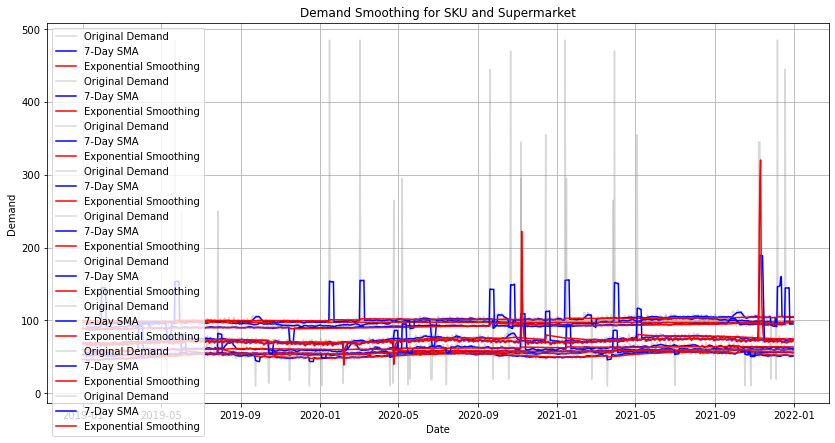

In [243]:
# # Plotting the original and smoothed data
# plt.figure(figsize=(14, 7))

# for sku in daily_data['sku'].unique():
#     for supermarket in daily_data['supermarket'].unique():
#         subset = daily_data[(daily_data['sku'] == sku) & (daily_data['supermarket'] == supermarket)]
#         if not subset.empty:
#             plt.plot(subset['date'], subset['demand'], label='Original Demand', color='gray', alpha=0.3)
#             plt.plot(subset['date'], subset['SMA_7'], label='7-Day SMA', color='blue')
#             plt.plot(subset['date'], subset['ES'], label='Exponential Smoothing', color='red')

# plt.title('Demand Smoothing for SKU and Supermarket')
# plt.xlabel('Date')
# plt.ylabel('Demand')
# plt.legend()
# plt.grid()
# plt.show()


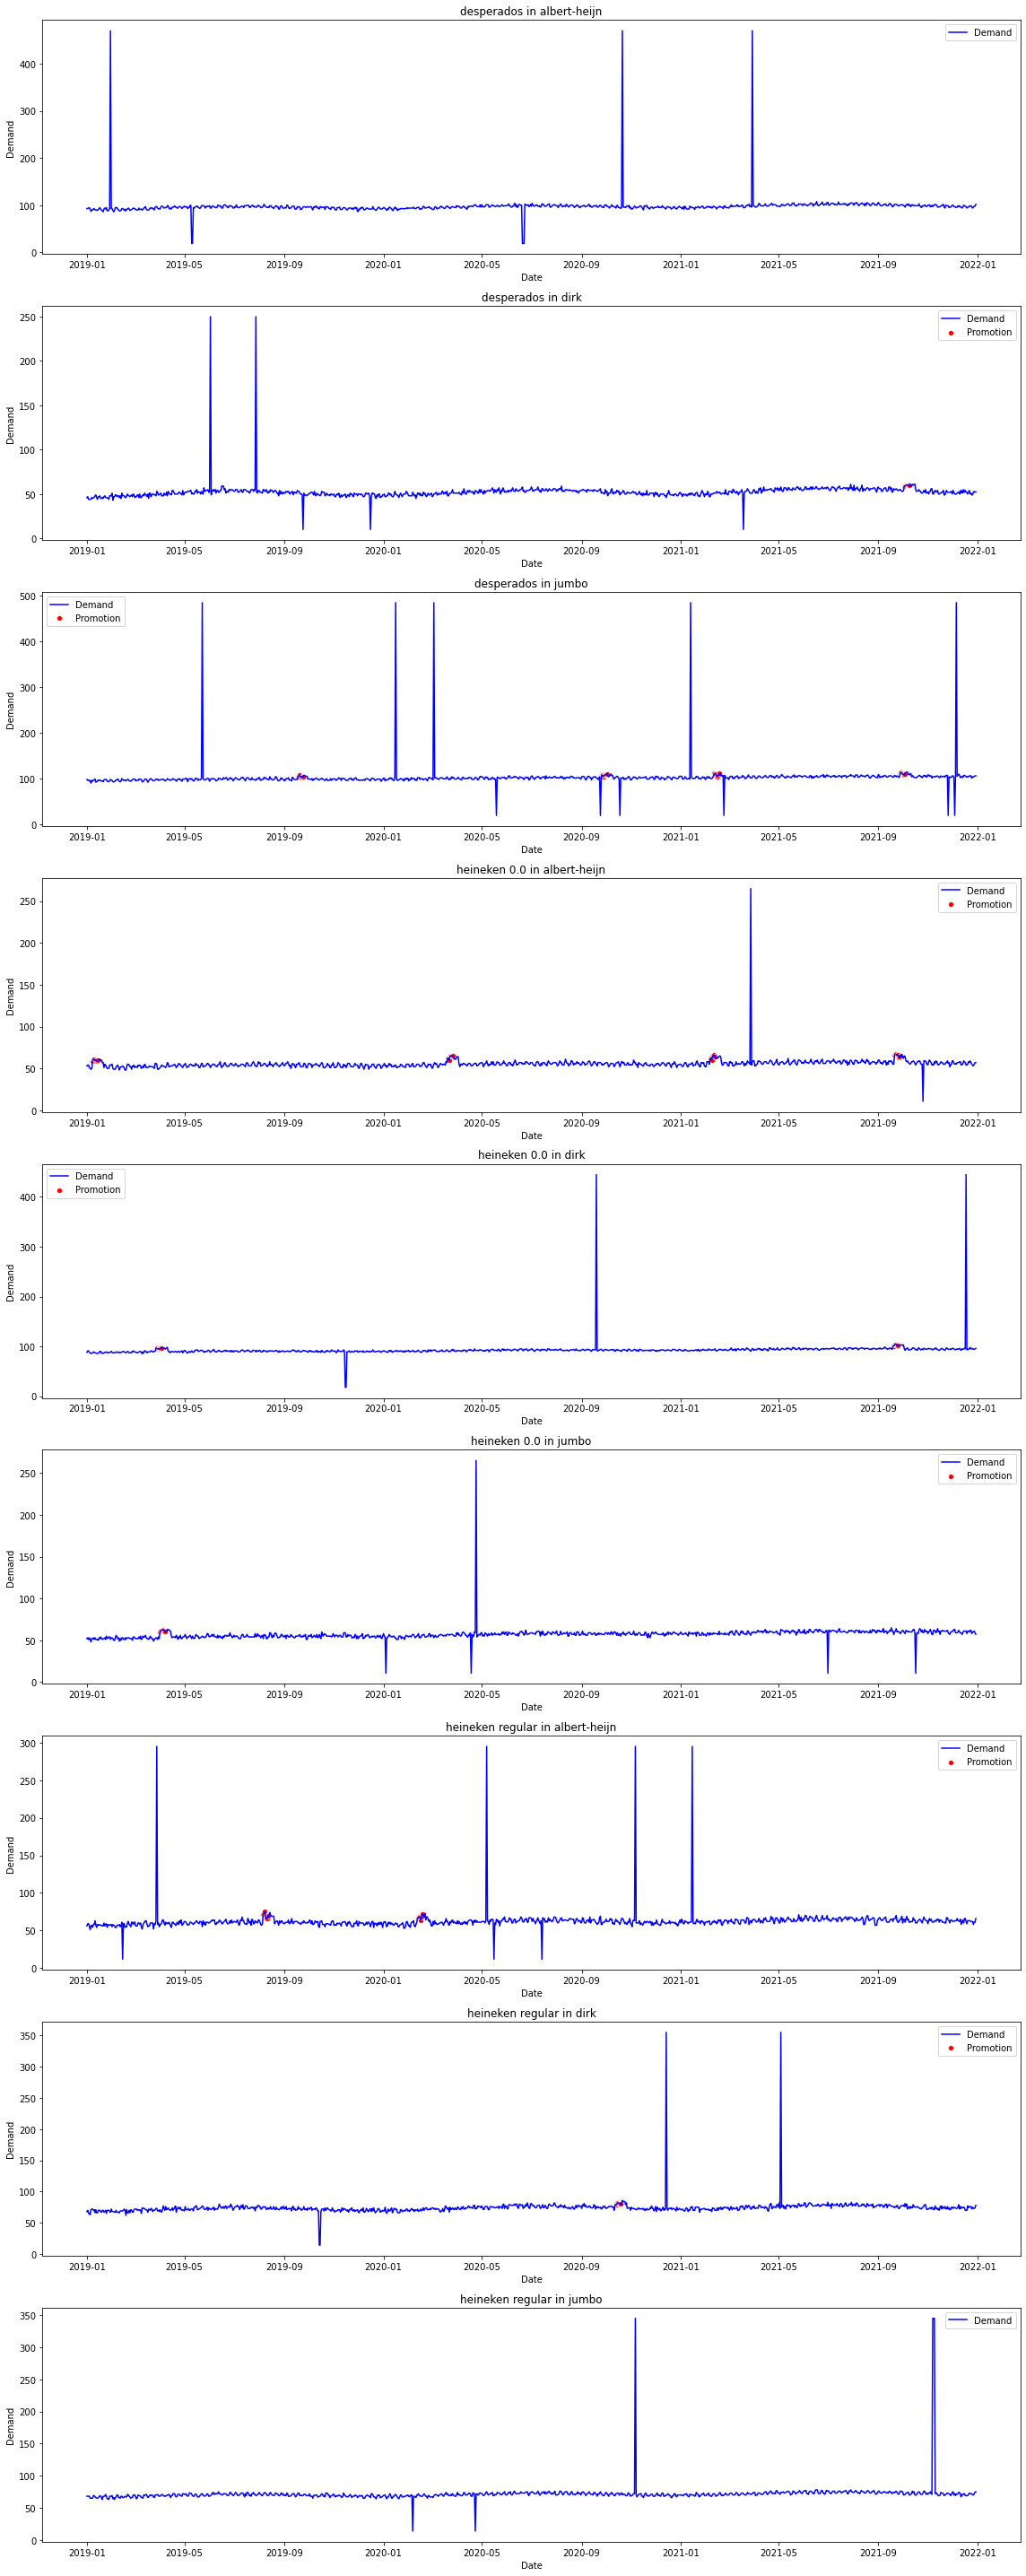

In [392]:
# Function to create a chart highlighting promotions
def plot_demand_with_promotion(group, sku, supermarket, ax):
    group = group.reset_index()

    # Draw the entire line in blue (without distinction on the page)
    sns.lineplot(
        x='date', 
        y='demand', 
        data=group, 
        color='blue', 
        label='Demand', 
        ax=ax
    )
    
    # Highlight in red the points where `promotion == True`
    sns.scatterplot(
        x='date', 
        y='demand', 
        data=group[group['promotion'] == True], 
        color='red', 
        label='Promotion', 
        ax=ax
    )


    ax.set_title(f'{sku} in {supermarket}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Demand')

grouped = df.groupby(['sku', 'supermarket'])

fig, axes = plt.subplots(9, 1, figsize=(16, 40))
axes = axes.flatten()

for ax, ((sku, supermarket), group) in zip(axes, grouped):
    plot_demand_with_promotion(group, sku, supermarket, ax)

plt.tight_layout()
plt.show()

There are many outliers in each group that can be captured with the code below.

In [393]:
def identify_outliers(df):
    outliers_dict = {}

    for (sku, supermarket), group in df.groupby(['sku', 'supermarket']):
        # Calculate IQR (Interquartile Range)
        Q1 = group['demand'].quantile(0.25)
        Q3 = group['demand'].quantile(0.75)
        IQR = Q3 - Q1
        
        # Ustal granice outlierów
        lower_bound = Q1 - 3 * IQR
        upper_bound = Q3 + 3 * IQR
        
        # Zidentyfikuj outliery
        outliers = group[(group['demand'] < lower_bound) | (group['demand'] > upper_bound)]
        outliers_dict[(sku, supermarket)] = outliers

    return outliers_dict

outliers = identify_outliers(df)
for key, value in outliers.items():
    print(f"Outliers for {key}:")
    print(value)


Outliers for ('desperados', 'albert-heijn'):
            demand         sku   supermarket  promotion  year  month  \
date                                                                   
2019-01-30   470.0  desperados  albert-heijn      False  2019      1   
2019-05-10    18.8  desperados  albert-heijn      False  2019      5   
2019-05-11    18.8  desperados  albert-heijn      False  2019      5   
2020-06-20    18.8  desperados  albert-heijn      False  2020      6   
2020-06-21    18.8  desperados  albert-heijn      False  2020      6   
2020-06-22    18.8  desperados  albert-heijn      False  2020      6   
2020-10-21   470.0  desperados  albert-heijn      False  2020     10   
2021-03-30   470.0  desperados  albert-heijn      False  2021      3   

            week_of_year  week_day  
date                                
2019-01-30             5         2  
2019-05-10            19         4  
2019-05-11            19         5  
2020-06-20            25         5  
2020-06-21  

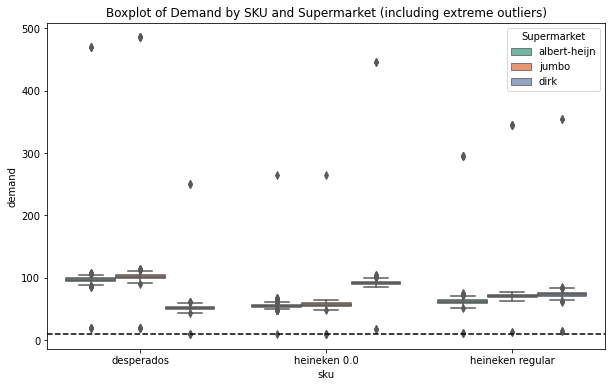

In [394]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='sku', y='demand', hue='supermarket', data=df, palette='Set2')
plt.title('Boxplot of Demand by SKU and Supermarket (including extreme outliers)')
plt.axhline(y=10, color='black', linestyle='--')
plt.legend(title='Supermarket')
plt.show()

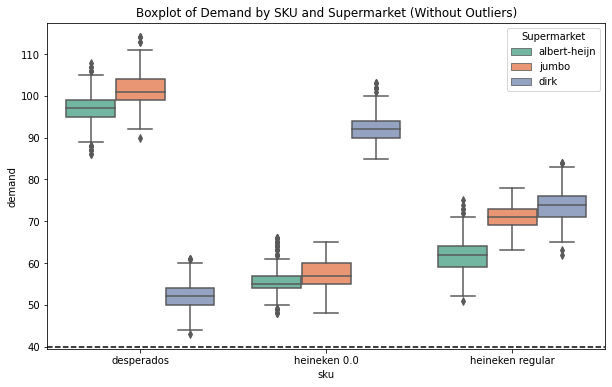

In [398]:
# Funkcja do identyfikacji outlierów
def identify_outliers(df):
    outliers_dict = {}
    
    for (sku, supermarket), group in df.groupby(['sku', 'supermarket']):
        Q1 = group['demand'].quantile(0.25)
        Q3 = group['demand'].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - 3 * IQR
        upper_bound = Q3 + 3 * IQR
        
        outliers = group[(group['demand'] < lower_bound) | (group['demand'] > upper_bound)]
        outliers_dict[(sku, supermarket)] = outliers.index.tolist()  # Przechowaj indeksy outlierów

    return outliers_dict

# Zidentyfikowanie outlierów
outliers = identify_outliers(df)

df_no_outliers = df.copy()
# Krok 2: Usuwanie outlierów z DataFrame
for index_list in outliers.values():
    df_no_outliers = df_no_outliers.drop(index_list, errors='ignore')  # Ignoruje błędy, jeśli indeks nie istnieje

# Krok 3: Rysowanie boxplotów bez outlierów
plt.figure(figsize=(10, 6))
sns.boxplot(x='sku', y='demand', hue='supermarket', data=df_no_outliers, palette='Set2')
plt.title('Boxplot of Demand by SKU and Supermarket (Without Outliers)')
plt.axhline(y=40, color='black', linestyle='--')  # Linia bazowa
plt.legend(title='Supermarket')
plt.show()


Check promotion impact

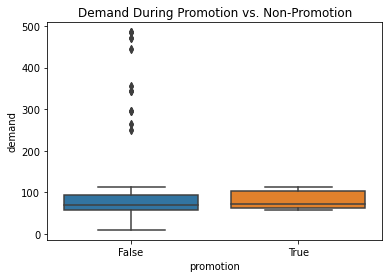

In [399]:
sns.boxplot(x='promotion', y='demand', data=df)
plt.title('Demand During Promotion vs. Non-Promotion')
plt.show()

In [400]:
promo_impact_mean = df.groupby('promotion')['demand'].mean()
print(f'mean: {promo_impact_mean}')
promo_impact_std = df.groupby('promotion')['demand'].std()
print(f'std: {promo_impact_std}')

mean: promotion
False    73.956915
True     81.361905
Name: demand, dtype: float64
std: promotion
False    24.079938
True     20.148069
Name: demand, dtype: float64


### Part 2: Exploration
The business wants to predict the demand for each SKU per supermarket _eight weeks in advance_. Perform any kind of explorative analysis that provides initial insights to answer this question historically. You are free to do any kind of analysis, but try to converge back to the business question at the end. 

Your final result should cover two main aspects:
1. You can report back some answers about demand to the business
2. You have initial understanding of the features that affect demand, to create a model next.

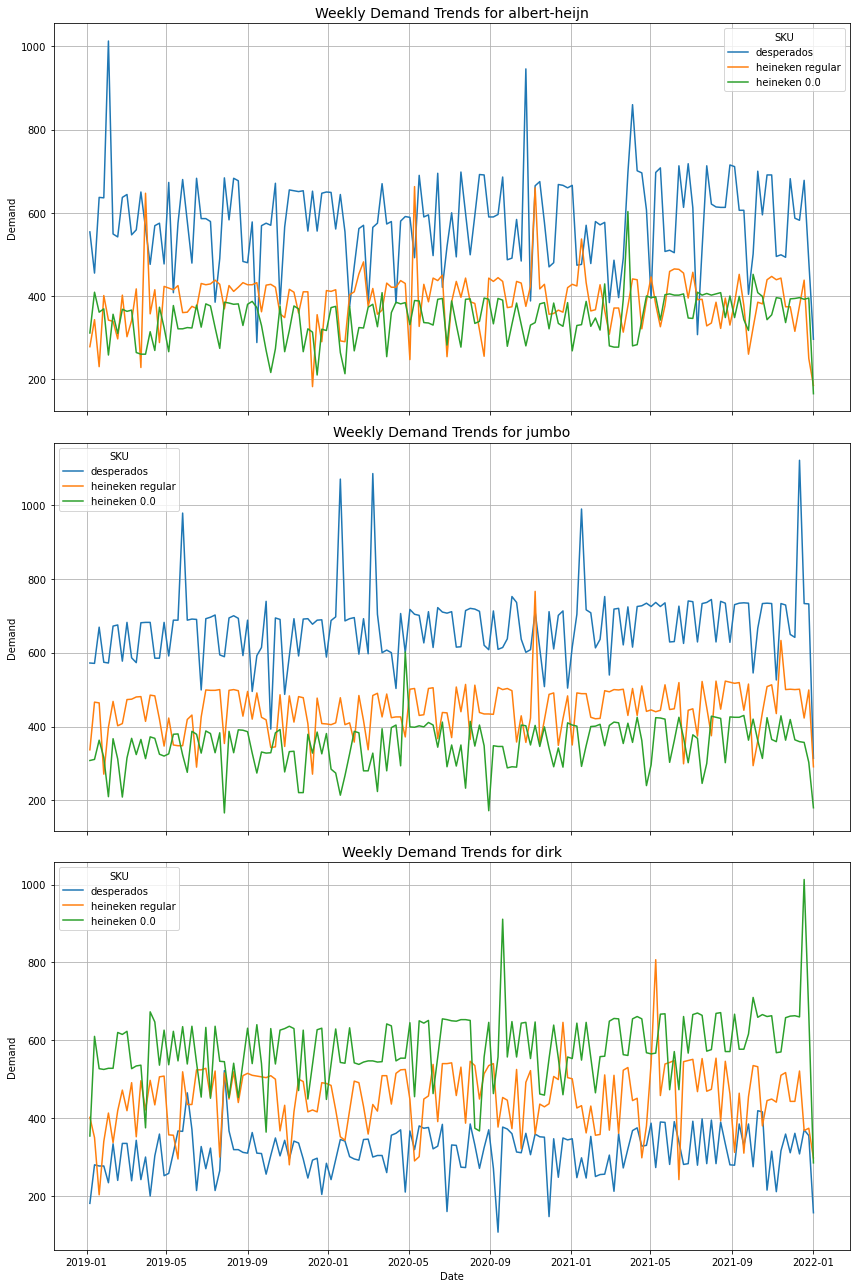

In [206]:
# Prepare figure layout to have each supermarket with its own subplot
supermarkets = df['supermarket'].unique()
skus = df['sku'].unique()

# Create subplots for each supermarket
fig, axes = plt.subplots(nrows=len(supermarkets), ncols=1, figsize=(12, 6*len(supermarkets)), sharex=True)

# Ensure axes is an array even if there's only one supermarket
if len(supermarkets) == 1:
    axes = [axes]

# Loop through each supermarket and create a subplot for the demand trends
for ax, supermarket in zip(axes, supermarkets):
    # Filter the data for the current supermarket
    df_supermarket = df[df['supermarket'] == supermarket]
    
    # Plot each SKU for the current supermarket on the same plot
    for sku in skus:
        df_sku = df_supermarket[df_supermarket['sku'] == sku]
        df_sku = df_sku.resample('W').sum()  # Resample demand data weekly
        
        ax.plot(df_sku.index, df_sku['demand'], label=sku)

    # Set titles and labels
    ax.set_title(f'Weekly Demand Trends for {supermarket}', fontsize=14)
    ax.set_ylabel('Demand')
    ax.legend(title='SKU')
    ax.grid(True)

# Set common X label
plt.xlabel('Date')
plt.tight_layout()
plt.show()

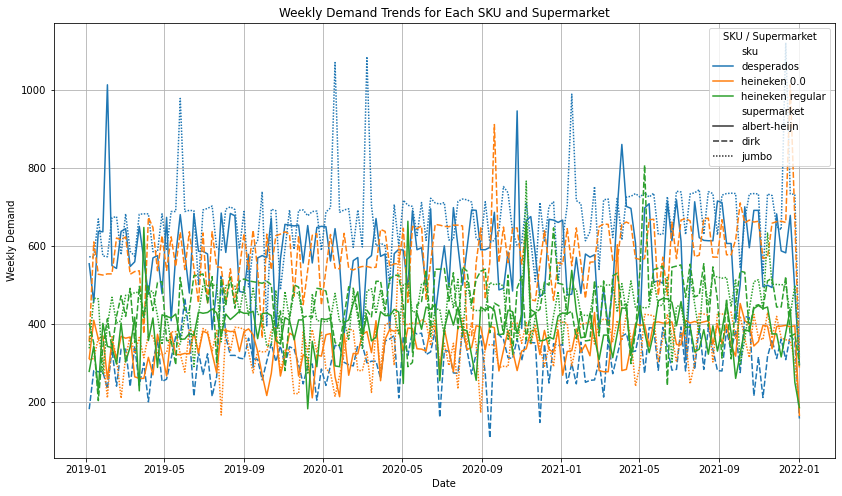

In [193]:
# Resample demand data weekly for each SKU and supermarket
df_weekly = df.groupby(['sku', 'supermarket']).resample('W').sum()['demand'].reset_index()

# Plot the weekly demand trends
plt.figure(figsize=(14, 8))
sns.lineplot(data=df_weekly, x='date', y='demand', hue='sku', style='supermarket')
plt.title('Weekly Demand Trends for Each SKU and Supermarket')
plt.ylabel('Weekly Demand')
plt.xlabel('Date')
plt.legend(loc='upper right', title='SKU / Supermarket')
plt.grid(True)
plt.show()

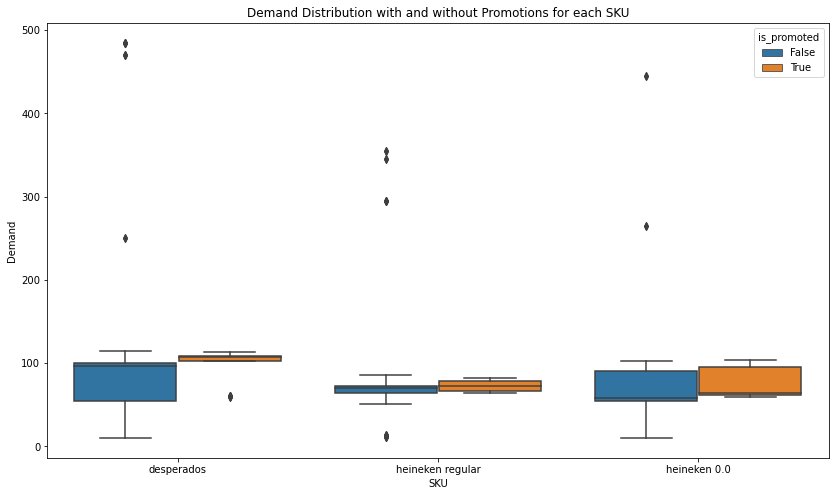

In [194]:
# Separate data into promotional and non-promotional periods
df['is_promoted'] = df['promotion'].astype(bool)

# Visualize demand with and without promotions
plt.figure(figsize=(14, 8))
sns.boxplot(data=df, x='sku', y='demand', hue='is_promoted')
plt.title('Demand Distribution with and without Promotions for each SKU')
plt.ylabel('Demand')
plt.xlabel('SKU')
plt.show()

Number of missing demand values: 1117


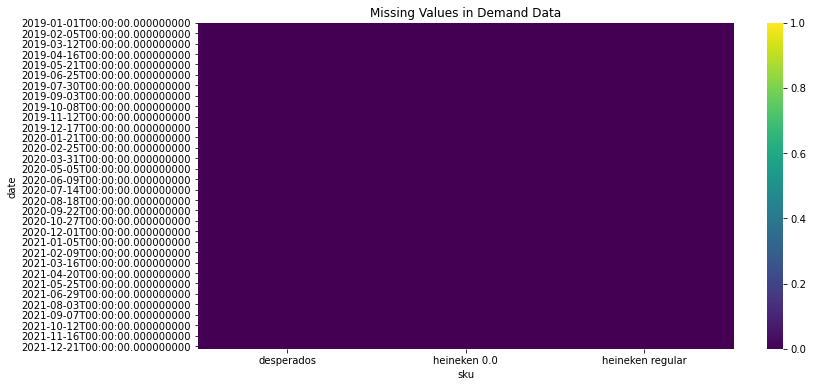

In [196]:
# Check for missing demand values
missing_values = df['demand'].isnull().sum()
print(f"Number of missing demand values: {missing_values}")

# Visualize where the missing values occur
plt.figure(figsize=(12, 6))
sns.heatmap(df.pivot_table(index='date', columns='sku', values='demand', aggfunc='mean').isnull(), cmap='viridis')
plt.title('Missing Values in Demand Data')
plt.show()

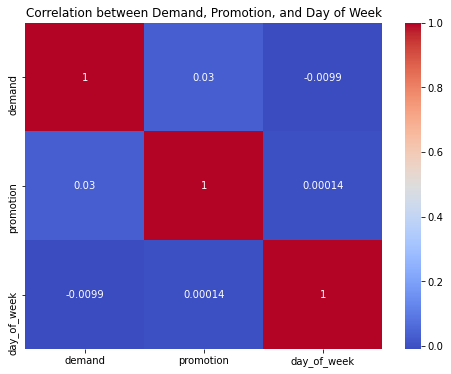

In [197]:
# Create new feature - Day of the Week
df['day_of_week'] = df.index.dayofweek

# Correlation heatmap between numerical variables
corr_df = df[['demand', 'promotion', 'day_of_week']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_df, annot=True, cmap='coolwarm')
plt.title('Correlation between Demand, Promotion, and Day of Week')
plt.show()